In [14]:
from call_functions import *
import matplotlib.pyplot as plt
import plotly.express as px

In [15]:
# ------------------------------
# Parameters to tune
# ------------------------------

x0 = 0
L = 2 * np.pi
Nx = 2**6 +1
Nf = Nx // 2
dt = 1e-3
a = 1
g = 1
gain = 1
T_start = 0
T = 500
N_ini_fq = 2**1

# ------------------------------
# Space discretization
# ------------------------------

dx = L / Nx
Lx = L - dx
xspan = np.arange(x0, Lx + dx, dx)
frequences = np.fft.fftfreq(Nx, dx) * 2 * np.pi
frequences2 = fftfreq(Nx, dx) * 2 * np.pi # same as above

# ------------------------------
# Time discretization
# ------------------------------

T_end = T_start + T
tspan = np.arange(T_start, T_end + dt, dt)
Nt = len(tspan)

In [16]:
frequences

array([  0.,   1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.,
        11.,  12.,  13.,  14.,  15.,  16.,  17.,  18.,  19.,  20.,  21.,
        22.,  23.,  24.,  25.,  26.,  27.,  28.,  29.,  30.,  31.,  32.,
       -32., -31., -30., -29., -28., -27., -26., -25., -24., -23., -22.,
       -21., -20., -19., -18., -17., -16., -15., -14., -13., -12., -11.,
       -10.,  -9.,  -8.,  -7.,  -6.,  -5.,  -4.,  -3.,  -2.,  -1.])

In [17]:
# 1) DFT and iDFT Matrices (as well as no mean matrices)
DFT = 1 / Nx * getDFT(Nx)
iDFT = getiDFT(Nx)

DFT_n_m = 1 / Nx * getDFT_no_mean(Nx)
iDFT_n_m = getiDFT_no_mean(Nx)

# 2) True matrix A not in Fourier
O = np.zeros((Nx, Nx))
I = np.eye(Nx)
G = Matrix_A_dz(Nx, dx)
_, C = GetC(np.abs(xspan - np.pi) <= a)
obs_space = np.abs(xspan - np.pi) <= a
C = -np.dot(C.T, C)
A = np.block([[O, -I], [G, C]])

# True matrix A in Fourier
fO = np.zeros((2 * Nf + 1, 2 * Nf + 1))
fI = -np.eye(2 * Nf + 1)
fF = np.diag(np.abs(np.concatenate((np.arange(0, Nf + 1), np.arange(-Nf, 0)))))# * 2 * np.pi)
frequences = fftfreq(Nx, dx) * 2 * np.pi  # Assuming the previously defined fftfreq function
fC = np.real(-((a * np.exp((-1j * np.pi) * (frequences.reshape(-1, 1) - frequences))) / np.pi) * np.sinc(a * (frequences.reshape(-1, 1) - frequences) / np.pi))
fA = np.block([[fO, fI], [fF, fC]])

# Matrix that deletes the mean
Pi_nm = np.diag(np.concatenate((np.zeros(1),np.ones(Nx-1))))

# Modified fA
fA_mod_nm = np.block([[fO, fI], [fF, Pi_nm @ fC]])

# vector with list of all the positive frequencices
pos_frequences = frequences[1:int((len(frequences)-1)/2)+1]

# Matrix that deletes the mean and the high frequencies
Pi_bf = np.diag(np.concatenate((np.zeros(1),(pos_frequences <= N_ini_fq),(pos_frequences <= N_ini_fq)[::-1])))
Pi_hf = np.diag(np.concatenate((np.zeros(1),(pos_frequences > N_ini_fq),(pos_frequences > N_ini_fq)[::-1])))

# second Modified fA
fA_mod_bf = np.block([[fO, fI], [fF, Pi_bf @ fC]])

In [18]:
Pi_bf

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 1.]])

In [19]:
print('list of frequences :')
print(2 * np.pi * fftfreq(Nx, dx))

list of frequences :
[  0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.
  14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.
  28.  29.  30.  31.  32. -32. -31. -30. -29. -28. -27. -26. -25. -24.
 -23. -22. -21. -20. -19. -18. -17. -16. -15. -14. -13. -12. -11. -10.
  -9.  -8.  -7.  -6.  -5.  -4.  -3.  -2.  -1.]


In [20]:
# Now : DFT @ fF @ iDFT = G

print('relative error between DFT @ fF @ iDFT and G :')
print(np.linalg.norm(np.real(iDFT @ fF @ DFT) - G)/np.linalg.norm(G))

# Now : DFT @ fF @ iDFT = G * np.pi * 2

print('relative error between DFT @ fC @ iDFT and C :')
print(np.linalg.norm(np.real(iDFT @ fC @ DFT) - C)/np.linalg.norm(C))

print('relative error between DFT @ fA @ iDFT and A :')
print(np.linalg.norm(np.real(np.kron(np.eye(2),DFT) @ fA @ np.kron(np.eye(2),iDFT)) - A)/np.linalg.norm(A))

relative error between DFT @ fF @ iDFT and G :
5.930223855214203e-15
relative error between DFT @ fC @ iDFT and C :
0.1934359125475558
relative error between DFT @ fA @ iDFT and A :
0.005708458913611578


In [21]:
px.scatter(x=frequences,y=[np.real(iDFT @ C @ DFT)[0,:],fC[0,:]])

In [22]:
def f(x):
    return np.sin(x)

print('freqs :',frequences)
print('real DFT :',(np.real(DFT @ f(xspan))) * (abs(np.real(DFT @ f(xspan))) > 1e-10))
print('imag DFT :',(np.imag(DFT @ f(xspan))) * (abs(np.imag(DFT @ f(xspan))) > 1e-10))
print('freqs :',frequences)
print('real ifft :',(np.real(np.fft.fft(f(xspan)))) * (abs(np.real(np.fft.fft(f(xspan)))) > 1e-10))
print('imag ifft :',(np.imag(np.fft.fft(f(xspan)))) * (abs(np.imag(np.fft.fft(f(xspan)))) > 1e-10))

freqs : [  0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.
  14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.
  28.  29.  30.  31.  32. -32. -31. -30. -29. -28. -27. -26. -25. -24.
 -23. -22. -21. -20. -19. -18. -17. -16. -15. -14. -13. -12. -11. -10.
  -9.  -8.  -7.  -6.  -5.  -4.  -3.  -2.  -1.]
real DFT : [ 0.  0. -0. -0. -0.  0. -0.  0.  0.  0.  0. -0.  0. -0.  0.  0.  0.  0.
  0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0.  0. -0.  0.  0.  0.  0. -0.
  0.  0.  0.  0.  0.  0. -0.  0. -0.  0. -0.  0.  0.  0. -0.  0.  0. -0.
  0. -0. -0.  0. -0. -0. -0. -0.  0. -0. -0.]
imag DFT : [ 0.  -0.5 -0.  -0.   0.   0.   0.  -0.  -0.  -0.  -0.  -0.   0.   0.
  0.   0.  -0.   0.   0.   0.   0.   0.   0.   0.  -0.   0.   0.  -0.
  0.  -0.   0.  -0.   0.  -0.   0.   0.   0.   0.   0.  -0.   0.  -0.
 -0.  -0.  -0.   0.  -0.   0.   0.  -0.  -0.   0.   0.   0.   0.   0.
 -0.   0.  -0.   0.   0.   0.   0.   0.   0.5]
freqs : [  0.   1.   2.   3.   4.   5.   6.   7

In [23]:
# initial condition in Fourier :
def create_Fourier_X0(nb_sin,nb_cos):
    sin_pos = np.random.rand(pos_frequences.shape[0]) * (pos_frequences <= nb_sin)
    cos_pos = np.random.rand(pos_frequences.shape[0]) * (pos_frequences <= nb_cos)
    X0 = np.concatenate((np.zeros(1),-sin_pos,sin_pos[::-1]))*1j + np.concatenate((np.zeros(1),cos_pos,cos_pos[::-1]))
    return X0

X0_sin = create_Fourier_X0(N_ini_fq,0)
X0_cos = create_Fourier_X0(0,N_ini_fq)
X0_mix = create_Fourier_X0(N_ini_fq,N_ini_fq)

print('number of frequences in initial condition :')
print(sum(abs(X0_sin) > 0))
print('number of positive frequences in initial condition :')
print(sum((abs(X0_sin) > 0) * (frequences > 0)))
print('number of negative frequences in initial condition :')
print(sum((abs(X0_sin) > 0) * (frequences < 0)))

number of frequences in initial condition :
4
number of positive frequences in initial condition :
2
number of negative frequences in initial condition :
2


In [24]:
X0_sin_space = iDFT @ (X0_sin)
print('mean of X0 :',np.mean(X0_sin))
px.line(x=xspan,y=[np.real(X0_sin_space),np.imag(X0_sin_space)])

mean of X0 : 0j


In [25]:
X0_mix_space = iDFT @ (X0_mix)
print('mean of X0 :',np.mean(X0_mix))
px.line(x=xspan,y=[np.real(X0_mix_space),np.imag(X0_mix_space)])

mean of X0 : (0.033818305858595514+0j)


In [26]:
fX0_sin = np.concatenate((X0_sin,X0_sin))
fX0_cos = np.concatenate((X0_cos,X0_cos))
fX0_mix = np.concatenate((X0_mix,X0_mix))

In [27]:
def Euler_Explicit(mat, X0, tspan):
    X = np.zeros((X0.shape[0],tspan.shape[0])) + np.zeros((X0.shape[0],tspan.shape[0]))*1j
    dt = tspan[1] - tspan[0]
    X[:,0] = X0
    for i in range(1,len(tspan)):
        X[:,i] = X[:,i-1] + dt * mat @ X[:,i-1]
    return X

In [28]:
X_sol_EE_fA_sin = Euler_Explicit(fA,fX0_sin,tspan)
print('1st edo : done')
X_sol_EE_fA_mod_nm_sin = Euler_Explicit(fA_mod_nm,fX0_sin,tspan)
print('2nd edo : done')
X_sol_EE_fA_mod_bf_sin = Euler_Explicit(fA_mod_bf,fX0_sin,tspan)
print('3rd edo : done')

1st edo : done
2nd edo : done
3rd edo : done


In [29]:
X_sol_EE_fA_cos = Euler_Explicit(fA,fX0_cos,tspan)
print('1st edo : done')
X_sol_EE_fA_mod_nm_cos = Euler_Explicit(fA_mod_nm,fX0_cos,tspan)
print('2nd edo : done')
X_sol_EE_fA_mod_bf_cos = Euler_Explicit(fA_mod_bf,fX0_cos,tspan)
print('3rd edo : done')

1st edo : done
2nd edo : done
3rd edo : done


In [30]:
X_sol_EE_fA_mix = Euler_Explicit(fA,fX0_mix,tspan)
print('1st edo : done')
X_sol_EE_fA_mod_nm_mix = Euler_Explicit(fA_mod_nm,fX0_mix,tspan)
print('2nd edo : done')
X_sol_EE_fA_mod_bf_mix = Euler_Explicit(fA_mod_bf,fX0_mix,tspan)
print('3rd edo : done')

1st edo : done
2nd edo : done
3rd edo : done


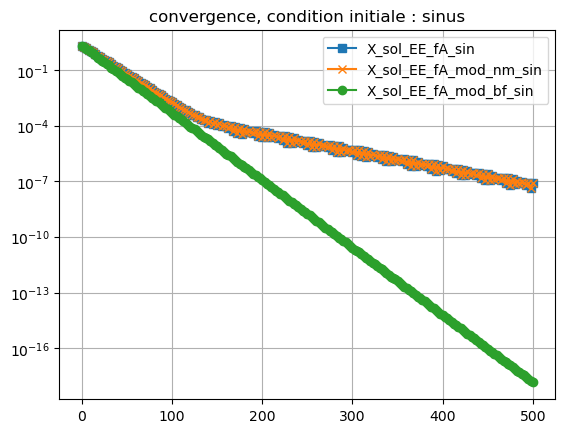

In [31]:
steps = tspan.shape[0]//200
plt.semilogy(tspan[::steps],np.linalg.norm(X_sol_EE_fA_sin[0:,::steps],2,axis=0),'-s',label='X_sol_EE_fA_sin')
plt.semilogy(tspan[::steps],np.linalg.norm(X_sol_EE_fA_mod_nm_sin[0:,::steps],2,axis=0),'-x',label='X_sol_EE_fA_mod_nm_sin')
plt.semilogy(tspan[::steps],np.linalg.norm(X_sol_EE_fA_mod_bf_sin[0:,::steps],2,axis=0),'-o',label='X_sol_EE_fA_mod_bf_sin')
plt.title(r'convergence, condition initiale : sinus')
plt.grid()
plt.legend()
plt.show()

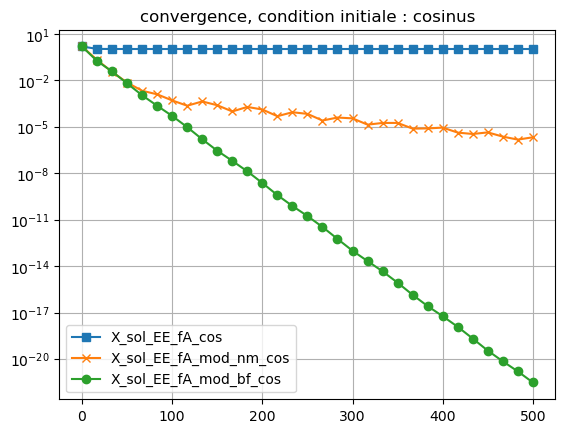

In [32]:
steps = tspan.shape[0]//30
plt.semilogy(tspan[::steps],np.linalg.norm(X_sol_EE_fA_cos[0:,::steps],2,axis=0),'-s',label='X_sol_EE_fA_cos')
plt.semilogy(tspan[::steps],np.linalg.norm(X_sol_EE_fA_mod_nm_cos[0:,::steps],2,axis=0),'-x',label='X_sol_EE_fA_mod_nm_cos')
plt.semilogy(tspan[::steps],np.linalg.norm(X_sol_EE_fA_mod_bf_cos[0:,::steps],2,axis=0),'-o',label='X_sol_EE_fA_mod_bf_cos')
plt.title(r'convergence, condition initiale : cosinus')
plt.grid()
plt.legend()
plt.show()

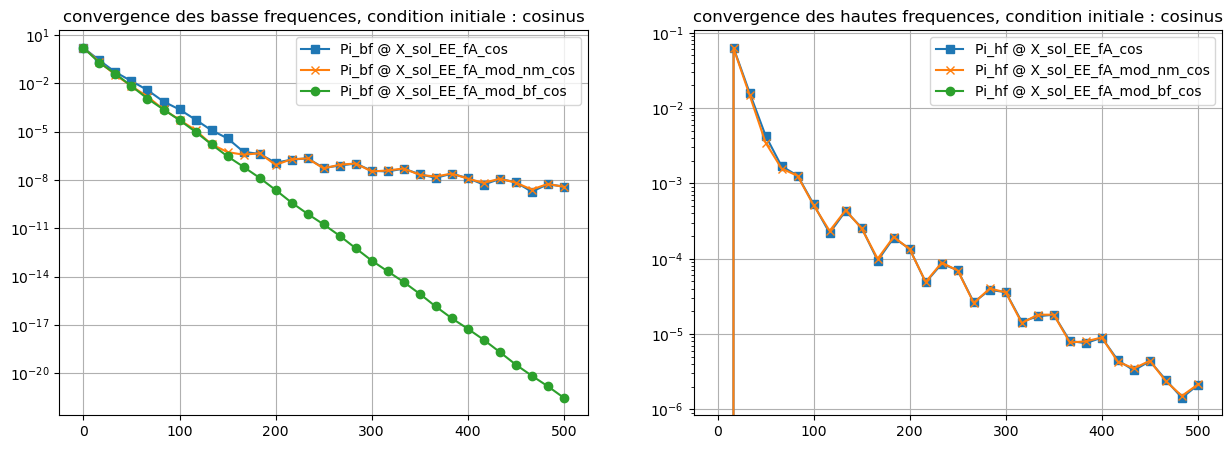

In [33]:
steps = tspan.shape[0]//30
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.semilogy(tspan[::steps],np.linalg.norm(np.kron(np.eye(2),Pi_bf) @ X_sol_EE_fA_cos[0:,::steps],2,axis=0),'-s',label='Pi_bf @ X_sol_EE_fA_cos')
plt.semilogy(tspan[::steps],np.linalg.norm(np.kron(np.eye(2),Pi_bf) @ X_sol_EE_fA_mod_nm_cos[0:,::steps],2,axis=0),'-x',label='Pi_bf @ X_sol_EE_fA_mod_nm_cos')
plt.semilogy(tspan[::steps],np.linalg.norm(np.kron(np.eye(2),Pi_bf) @ X_sol_EE_fA_mod_bf_cos[0:,::steps],2,axis=0),'-o',label='Pi_bf @ X_sol_EE_fA_mod_bf_cos')
plt.title(r'convergence des basse frequences, condition initiale : cosinus')
plt.grid()
plt.legend()
plt.subplot(1, 2, 2)
plt.semilogy(tspan[::steps],np.linalg.norm(np.kron(np.eye(2),Pi_hf) @ X_sol_EE_fA_cos[0:,::steps],2,axis=0),'-s',label='Pi_hf @ X_sol_EE_fA_cos')
plt.semilogy(tspan[::steps],np.linalg.norm(np.kron(np.eye(2),Pi_hf) @ X_sol_EE_fA_mod_nm_cos[0:,::steps],2,axis=0),'-x',label='Pi_hf @ X_sol_EE_fA_mod_nm_cos')
plt.semilogy(tspan[::steps],np.linalg.norm(np.kron(np.eye(2),Pi_hf) @ X_sol_EE_fA_mod_bf_cos[0:,::steps],2,axis=0),'-o',label='Pi_hf @ X_sol_EE_fA_mod_bf_cos')
plt.title(r'convergence des hautes frequences, condition initiale : cosinus')
plt.grid()
plt.legend()
plt.show()

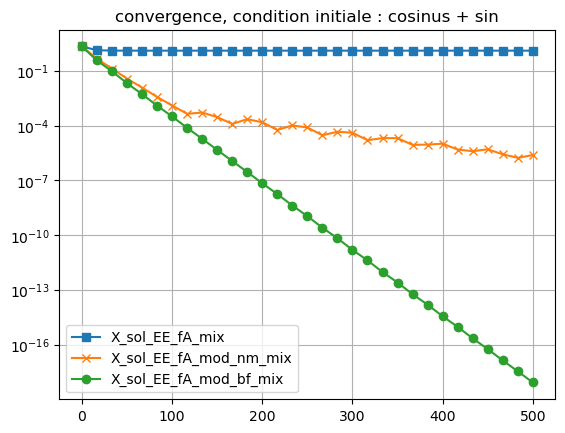

In [38]:
steps = tspan.shape[0]//30
plt.semilogy(tspan[::steps],np.linalg.norm(X_sol_EE_fA_mix[0:,::steps],2,axis=0),'-s',label='X_sol_EE_fA_mix')
plt.semilogy(tspan[::steps],np.linalg.norm(X_sol_EE_fA_mod_nm_mix[0:,::steps],2,axis=0),'-x',label='X_sol_EE_fA_mod_nm_mix')
plt.semilogy(tspan[::steps],np.linalg.norm(X_sol_EE_fA_mod_bf_mix[0:,::steps],2,axis=0),'-o',label='X_sol_EE_fA_mod_bf_mix')
plt.title(r'convergence, condition initiale : cosinus + sin')
plt.grid()
plt.legend()
plt.show()

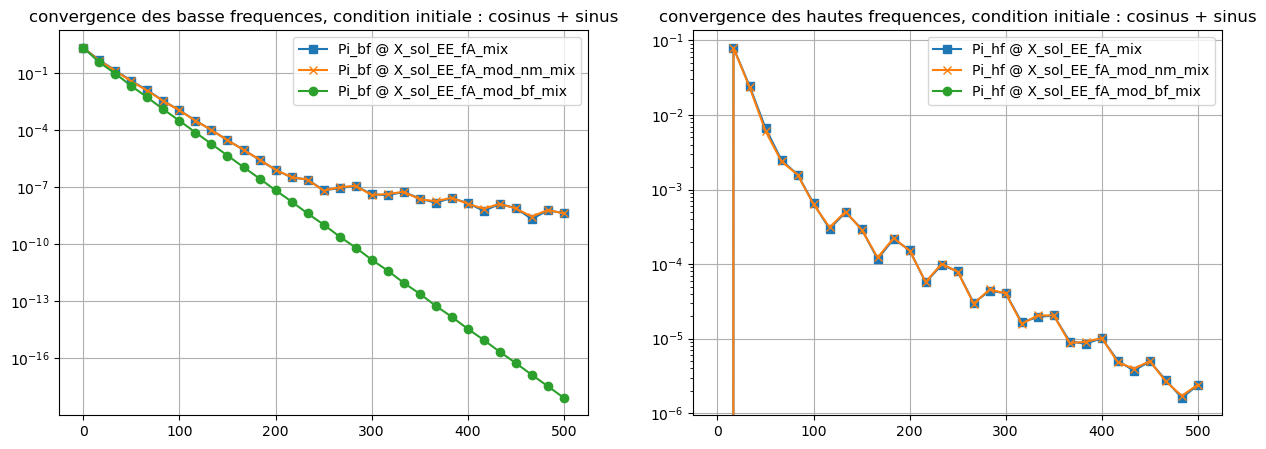

In [37]:
steps = tspan.shape[0]//30
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.semilogy(tspan[::steps],np.linalg.norm(np.kron(np.eye(2),Pi_bf) @ X_sol_EE_fA_mix[0:,::steps],2,axis=0),'-s',label='Pi_bf @ X_sol_EE_fA_mix')
plt.semilogy(tspan[::steps],np.linalg.norm(np.kron(np.eye(2),Pi_bf) @ X_sol_EE_fA_mod_nm_mix[0:,::steps],2,axis=0),'-x',label='Pi_bf @ X_sol_EE_fA_mod_nm_mix')
plt.semilogy(tspan[::steps],np.linalg.norm(np.kron(np.eye(2),Pi_bf) @ X_sol_EE_fA_mod_bf_mix[0:,::steps],2,axis=0),'-o',label='Pi_bf @ X_sol_EE_fA_mod_bf_mix')
plt.title(r'convergence des basse frequences, condition initiale : cosinus + sinus')
plt.grid()
plt.legend()
plt.subplot(1, 2, 2)
plt.semilogy(tspan[::steps],np.linalg.norm(np.kron(np.eye(2),Pi_hf) @ X_sol_EE_fA_mix[0:,::steps],2,axis=0),'-s',label='Pi_hf @ X_sol_EE_fA_mix')
plt.semilogy(tspan[::steps],np.linalg.norm(np.kron(np.eye(2),Pi_hf) @ X_sol_EE_fA_mod_nm_mix[0:,::steps],2,axis=0),'-x',label='Pi_hf @ X_sol_EE_fA_mod_nm_mix')
plt.semilogy(tspan[::steps],np.linalg.norm(np.kron(np.eye(2),Pi_hf) @ X_sol_EE_fA_mod_bf_mix[0:,::steps],2,axis=0),'-o',label='Pi_hf @ X_sol_EE_fA_mod_bf_mix')
plt.title(r'convergence des hautes frequences, condition initiale : cosinus + sinus')
plt.grid()
plt.legend()
plt.show()